# Project 2: Digit Classification Naive Bayes

**Solution**

# Intro
---
In this project, you'll continue working on your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. 
As always, you're welcome to work on the project in groups and discuss ideas over Slack, but <b> please prepare your own write-up (with your own code). </b>


## Grading
---
 - Make sure to answer every part in every question.
 - There are 6 questions, each equally weighted and an additional bonus question.
 - The extra credit question will be graded based on your attempts at feature engineering and resulting improved accuracy.
 - Read carefully what is asked including the notes.
 - Additional points may be deducted if:
   - the code is not clean, well commented,
  -  if the functions or answers are too long.

## Requirements:
---
1. Comment your code.
1. All graphs should have titles, label for each axis, and if needed a legend. It should be understandable on its own.
1. All code must run on colab.research.google.com
1. You should not import any additional libraries.
1. Try and minimize the use of the global namespace (meaning keep things in functions).

## Additional Reading and notes
---
If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

In [2]:
import sklearn
sklearn.__version__

'0.23.2'

Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [3]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)

# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]

data shape:  (70000, 784)
label shape: (70000,)


### Question 1: Applying a smoothing using numpy.
---

A common image processing technique is to smooth an image by **blurring**. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

1. Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.
1. Choose some weights as a starting point. Produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
  1. Do not use the filter
  1. Filter the training data but not the dev data
  1. Filter the dev data but not the training data
  1. Filter both training data and dev data
1. Show the accuracies of the four models evaluated as described. What do you see? Can you explain why this is?
1. Experiment with weights that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* A good trick to simplify your code is to use numpy's pad function to add 0s around your original array so you don't have to deal with "edge cases".
* In addition, you can use numpy to multiply and sum slices of two arrays.
* [This notebook](https://colab.research.google.com/drive/1eJXTQLtREXQjQIsLOA9uCrBl6B049-pO) might help shows some example numpy code.
* In general, [numpy operations will be much faster than for loops](https://colab.research.google.com/drive/1KJI4JtuIqVdyZHTTe_mAlKYA5XdLFp3_). 
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but in this question, please implement your own.

No Filter: 1-Nearest Neighbor fit
           Accuracy: 0.884
--------------------------------------------
Blur Train Data: 1-Nearest Neighbor fit
           Accuracy: 0.891

    Images of a few of the blurred digits


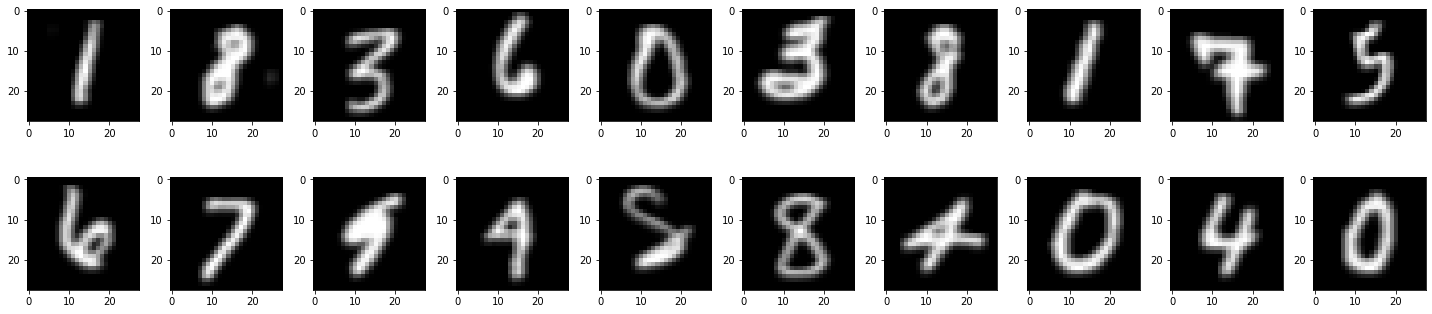

--------------------------------------------
Blur Dev Data: 1-Nearest Neighbor fit
           Accuracy: 0.871
--------------------------------------------
Blur Train, Dev data: 1-Nearest Neighbor fit
           Accuracy: 0.908


In [4]:
def Q1():
    
### STUDENT START ###

    def weighted_blur(image_data, nbrs=8):
        ''' image_data: an np array containing normalized (divided by 255) pixel value
            nbrs: # of neighbors to be considered for every pixel in 2^n; 2^3 by default
            
            Reshape image to a 28x28 matrix; pad this matrix with a row of 0s top and
            bottom, and by a column of 0s on either side. So, 28x28 matrix is now 30x30.
            
            Starting from row = 1 till row = 27 followed by column = 1 till column = 27
            (i.e for every pixel) extract a submatrix using index [row-1:3, column-1:3].
            
            Calculate the weighted average of the submatrix with the weight matrix to 
            form the new pixel
            
            Return the new matrix
        '''
        
        sz = int(np.sqrt(image_data.shape[1])) # sqrt(784) for shaping into matrix
        nbr_cnt = int(np.log2(nbrs)) # number of neighbor rows/columns for each pixel
        wt = np.arange(.1, 1, .1).reshape(nbr_cnt, nbr_cnt) # used in weighthed avg. calc
        wt_image_data = np.empty([0, image_data.shape[1]]) # init, to append new images
        
        for i in range(len(image_data)): # for every image in the data
            image = (image_data[i]).reshape(sz, sz) # make it into 28x28 matrix
            new_image = np.copy(image) # make a copy to overwrite with weighted calculations
            image = np.pad(image, 1, mode='constant') # pad with 0s around to get 30x30 matrix
            
            for row in range(len(image) - 2): # for every row except padded rows
                for col in range(len(image) - 2): # for evey col except padded cols
                    new_image[row][col] = np.average(image[row: row+nbr_cnt, col: col+nbr_cnt], 
                                                     weights=wt) # weighted sum for new pixel
            
            new_image = new_image.flatten() # convert 28x28 array into 1-dim array
            wt_image_data = np.append(wt_image_data, [new_image], axis=0) # same shape as image_data
                   
        return(wt_image_data)
            
    def plot_digits(d):
        fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
        for i in range(1, 11): 
            digit_px = d[i*50-1]
            digit_px_image = digit_px.reshape(28, 28) 
            ax = axes[0, i-1] 
            ax.imshow(digit_px_image, cmap="gray")
        for i in range(11, 21):
            digit_px = d[i*50-1]
            digit_px_image = digit_px.reshape(28, 28) 
            ax = axes[1, i-11] 
            ax.imshow(digit_px_image, cmap="gray")
        fig.tight_layout()
        plt.show()
    
    def fit_1_NN(train_d, train_l, dev_d, dev_l, msg):
        classifier = KNeighborsClassifier(n_neighbors=1)
        classifier.fit(train_d, train_l)
        y_pred = classifier.predict(dev_d)
        r = classification_report(dev_l, y_pred, output_dict=True)
        print(msg)
        print("           Accuracy: %0.3f" % r['accuracy'])
        
            
    
    fit_1_NN(mini_train_data, mini_train_labels, dev_data, dev_labels,
             "No Filter: 1-Nearest Neighbor fit" )
    print("--------------------------------------------")    
    
    wt_mini_train_data = weighted_blur(mini_train_data)
    fit_1_NN(wt_mini_train_data, mini_train_labels,dev_data, dev_labels, 
             "Blur Train Data: 1-Nearest Neighbor fit")
    print()
    print("    Images of a few of the blurred digits")
    plot_digits(wt_mini_train_data)
    print("--------------------------------------------")
            
    wt_dev_data = weighted_blur(dev_data)
    fit_1_NN(mini_train_data, mini_train_labels, wt_dev_data, dev_labels, 
             "Blur Dev Data: 1-Nearest Neighbor fit")
    print("--------------------------------------------")
            
    fit_1_NN(wt_mini_train_data, mini_train_labels, wt_dev_data, dev_labels, 
             "Blur Train, Dev data: 1-Nearest Neighbor fit")

### STUDENT END ###

Q1()

### Answer to 3:
The 1-nearest Neighbor model does a decent job. We get an accuracy of 0.884. When we blur the training data the accuracy goes up to 0.891. However, when we blur only the dev_data we see a reduction in the accuracy. This is because of the fact that the training happened without blurring but the prediction is run on blurred data. The model was trained on non-blurred data. So, the model is better off predicting non-blurred data. Finally, when we use bluured data for both the training and testing we get an accuracy of a little over 0.9. 


### Question 2: Modeling your data and experimenting with different Naive Bayes models. 
---

1. Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.
  1. For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.
  1. For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Here you'll likely need to implement a `trianarize` helper function. Since we are going beyond the binary representation of our features, you should use `MultinomialNB` to produce the model.
1. Show the Bernoulli model accuracy and the Multinomial model accuracy.
1. Does the multinomial version improve the results? Why or why not?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.



In [5]:
# Solution with binarization by explicit binarize function

def Q2():

### STUDENT START ###
    def binarize_trinarize(d, threshold):
        ''' d: np array whose values will be used to check against the thresghold
            threshold: list of threshold values to be used - 1 element mean binarize,
                       2 elements mean trinarize
            If binarize (only 1 element in threshold list), check if each element in 
            d is < the threshold and if so mark 0; else mark 1.
            If trinarize (2 elements in threshold) then 
                - if elements in d is lower than 1st threshold set it to 0 
                - if elements in d > 2nd threshold set it to 2
                - if neither set then set it to 1
        '''       
        if len(threshold) == 1:
            bin_data = np.zeros(d.shape) # init an array of all zero to match the incoming array DIMs
            bin_data[(d >= threshold[0])] = 1
        elif len(threshold) == 2:
            bin_data = np.ones(d.shape) # init an array of all zero to match the incoming array DIMs
            bin_data[(d > threshold[1])] = 2
            bin_data[(d < threshold[0])] = 0
        else:
            print("Wrong threshold list specification")
            return None
        
        return bin_data
    
    # run BernoulliNB with binarized data
    bin_mini_train_data = binarize_trinarize(mini_train_data, [0.1])
    bin_dev_data = binarize_trinarize(dev_data, [0.1])
    
    model_bin = BernoulliNB()
    model_bin.fit(bin_mini_train_data, mini_train_labels)
    accuracy = model_bin.score(bin_dev_data, dev_labels)
    print("Bernoulli Navie Bayes model with Binarized Data")
    print("           Accuracy: %0.3f" % accuracy)
    print()
    
    # run MultinomialNB
    tri_mini_train_data = binarize_trinarize(mini_train_data, [0.1, 0.9])
    tri_dev_data = binarize_trinarize(dev_data, [0.1, 0.9])
    
    model_tri = MultinomialNB()
    model_tri.fit(tri_mini_train_data, mini_train_labels)
    accuracy = model_tri.score(tri_dev_data, dev_labels)
    print("Multinomial Navie Bayes model with Trinarized Data")
    print("           Accuracy: %0.3f" % accuracy)
    
### STUDENT END ###

Q2()

Bernoulli Navie Bayes model with Binarized Data
           Accuracy: 0.814

Multinomial Navie Bayes model with Trinarized Data
           Accuracy: 0.807


ANSWER: 
The MultinomialNB model performs somewhat lower in terms of accuracy as can be seen by the resutls. Very likely, the case is that adding an additional categorical variable is really not helping. The picture is pretty much explained by whether a black or white pixel exists in each elemnet of the 28x28 grid. The additional of the gray category takes away from black and doesn't add much. 

Note: If anything, playing with the alpha value in BenoulliNB may be a better option to get better accuracy. While I haven't shown the code an alpha value of 0.005 does increase the accuracu to 0.83.

### Question 3: Applying the grid search technique.
1. Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.
1. What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.



In [6]:
def Q3(alphas):

### STUDENT START ###
    
    bin_mini_train_data = np.zeros(mini_train_data.shape) # create an all 0 array
    bin_dev_data = np.zeros(dev_data.shape)
    
    bin_mini_train_data[(mini_train_data >= 0.1)] = 1 # flip to 1 based on threshold (0.1)
    bin_dev_data[(dev_data >= 0.1)] = 1
    
    model_grid = GridSearchCV(estimator=BernoulliNB(binarize=0.0), param_grid=alphas, 
                             cv=5, scoring="accuracy") # create the grid model
    
    model_grid.fit(bin_mini_train_data, mini_train_labels) # train on the binarized train data
    #model_grid.fit(mini_train_data, mini_train_labels)
    
    r = model_grid.score(bin_dev_data, dev_labels) 
    #r = model_grid.score(dev_data, dev_labels)
    
    res_grid_scores = model_grid.cv_results_['mean_test_score']
    
    
    print("Best estimator:", model_grid.best_estimator_, "has optiaml alpha", model_grid.best_params_['alpha'])
    print("Best Accuracy obtained:", r)
    print("Accuracies obained are:", res_grid_scores)
    
    print("  Alpha  ", "         Accuracy")
    for i in range(len(res_grid_scores)):
        accuracy = res_grid_scores[i]
        if i == 0:
            print("  ",alphas['alpha'][i], "           %0.3f" % accuracy)
        elif i == len(res_grid_scores) - 1:
            print(" %2.4f" % alphas['alpha'][i], "           %0.3f" % accuracy)
        else:
            print("  %2.4f" % alphas['alpha'][i], "           %0.3f" % accuracy)

### STUDENT END ###

alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
Q3(alphas)


Best estimator: BernoulliNB(alpha=0.01) has optiaml alpha 0.01
Best Accuracy obtained: 0.83
Accuracies obained are: [0.823 0.826 0.826 0.829 0.819 0.823 0.815 0.816 0.791]
  Alpha            Accuracy
   1e-10            0.823
  0.0001            0.826
  0.0010            0.826
  0.0100            0.829
  0.1000            0.819
  0.5000            0.823
  1.0000            0.815
  2.0000            0.816
 10.0000            0.791


ANSWER: 
We get the best accuracy when alpha = 0.01.

When alpha is near zero the accuracy is lower. The difference, for the set of alphas provided, is close 0.006, for the lowest alpha value. The alpha value has the effect of smoothing the extremes - alpha substitutes itself for the case of zero-valued pixels. As alpha grows slowly from 0 it improve accuracy up to a point (0.01 in this case). Subsequent growth of alpha isn't helping any more. In fact, it influences pixel values of 0 so much that the accuracy of predection goes down.

### Question 4: Experimenting with Gaussian Naive Bayes
---
1. Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. 
1. Diagnose and explain the problem.
1. Apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. 
1. Show the model accuracy before your fix and the model accuracy after your fix.  
1. Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Take a look at var_smoothing argument for GaussianNB.
* Feel free to  examine theta and sigma to better understand what's happening. In general though, **it is not a good idea to mess with internal variables of the model**. These are stored in the model's `theta_` and `sigma_` attributes.

In [7]:
def Q4():

### STUDENT END ###
    model_GNB = GaussianNB() # init Gaussian Naive Bayes
    model_GNB.fit(mini_train_data, mini_train_labels) # train with the mini_train_data
    
    model_GNB_score = model_GNB.score(dev_data, dev_labels)
    
    print("Accuracy score from Gaussian Naive Bais (no smoothing fix):", model_GNB_score)
    
    
    model_smooth_GNB = GaussianNB(var_smoothing = 0.086)
    model_smooth_GNB.fit(mini_train_data, mini_train_labels)
    
    model_smooth_GNB_score = model_smooth_GNB.score(dev_data, dev_labels)
    
    print("Accuracy score from Gaussian Naive Bais (with smoothing fix):", model_smooth_GNB_score)
    
### STUDENT END ###

Q4()

Accuracy score from Gaussian Naive Bais (no smoothing fix): 0.593
Accuracy score from Gaussian Naive Bais (with smoothing fix): 0.819


ANSWER: 
The Gaussian Naive Bayes gives a poor accuracy score in its default form for this data case. The matrix of image pixel values have fair amount of zeros, which in turn leads to several multiplication by zero effects. 

This is where the var_smoothing parameter in the GaussianNB helps. This parameter adds to the variance. Adding a small variance (similar to alpha in BernoulliNB) we can improve the model.

As shown by the results, the smoothing fix does improve the accuracy. After a few iterations the values between 0.84 to 0.88 seems to be at least a local maxima - i.e values between 0.84 and 0.88 gives an accuracy of 0.819, while lower than 0.84 or higher that 0.88 seems to reduce accuracy, though, very slowly.

A Gaussian curve is a like a band-pass filter around the mean - the most allowed values are around the mean. If the mean is 0 or close to zero it's like a low-pass filter, allowing values near 0 to flow through Vs the more spread out values. This kind of filtering may not be appropriate as in the case of the image matrix - includes values closer to 0 and dropping off quickly as we move away from 0. By adding a small value to the variance through the var_smoothing parameter we smooth/flatten/broaden the curve, allowing more values to be included. This leads to better accuracy.

### Question 5: Naive Bayes as a generative model
---
Because Naive Bayes produces a generative model, you can use it to generate digit images.

1. Produce a Bernoulli Naive Bayes model and then use it to generate a 10x10 grid with 10 example images of each digit. Each pixel output will be either 0 or 1: randomly generating a number and then comparing it to the estimated probability of the pixel being either 0 or 1.  Show the grid.
1. How do the generated digit images compare to the training digit images?

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.



Shape of model_BNB_prob: (10, 784)

Generated Digits:


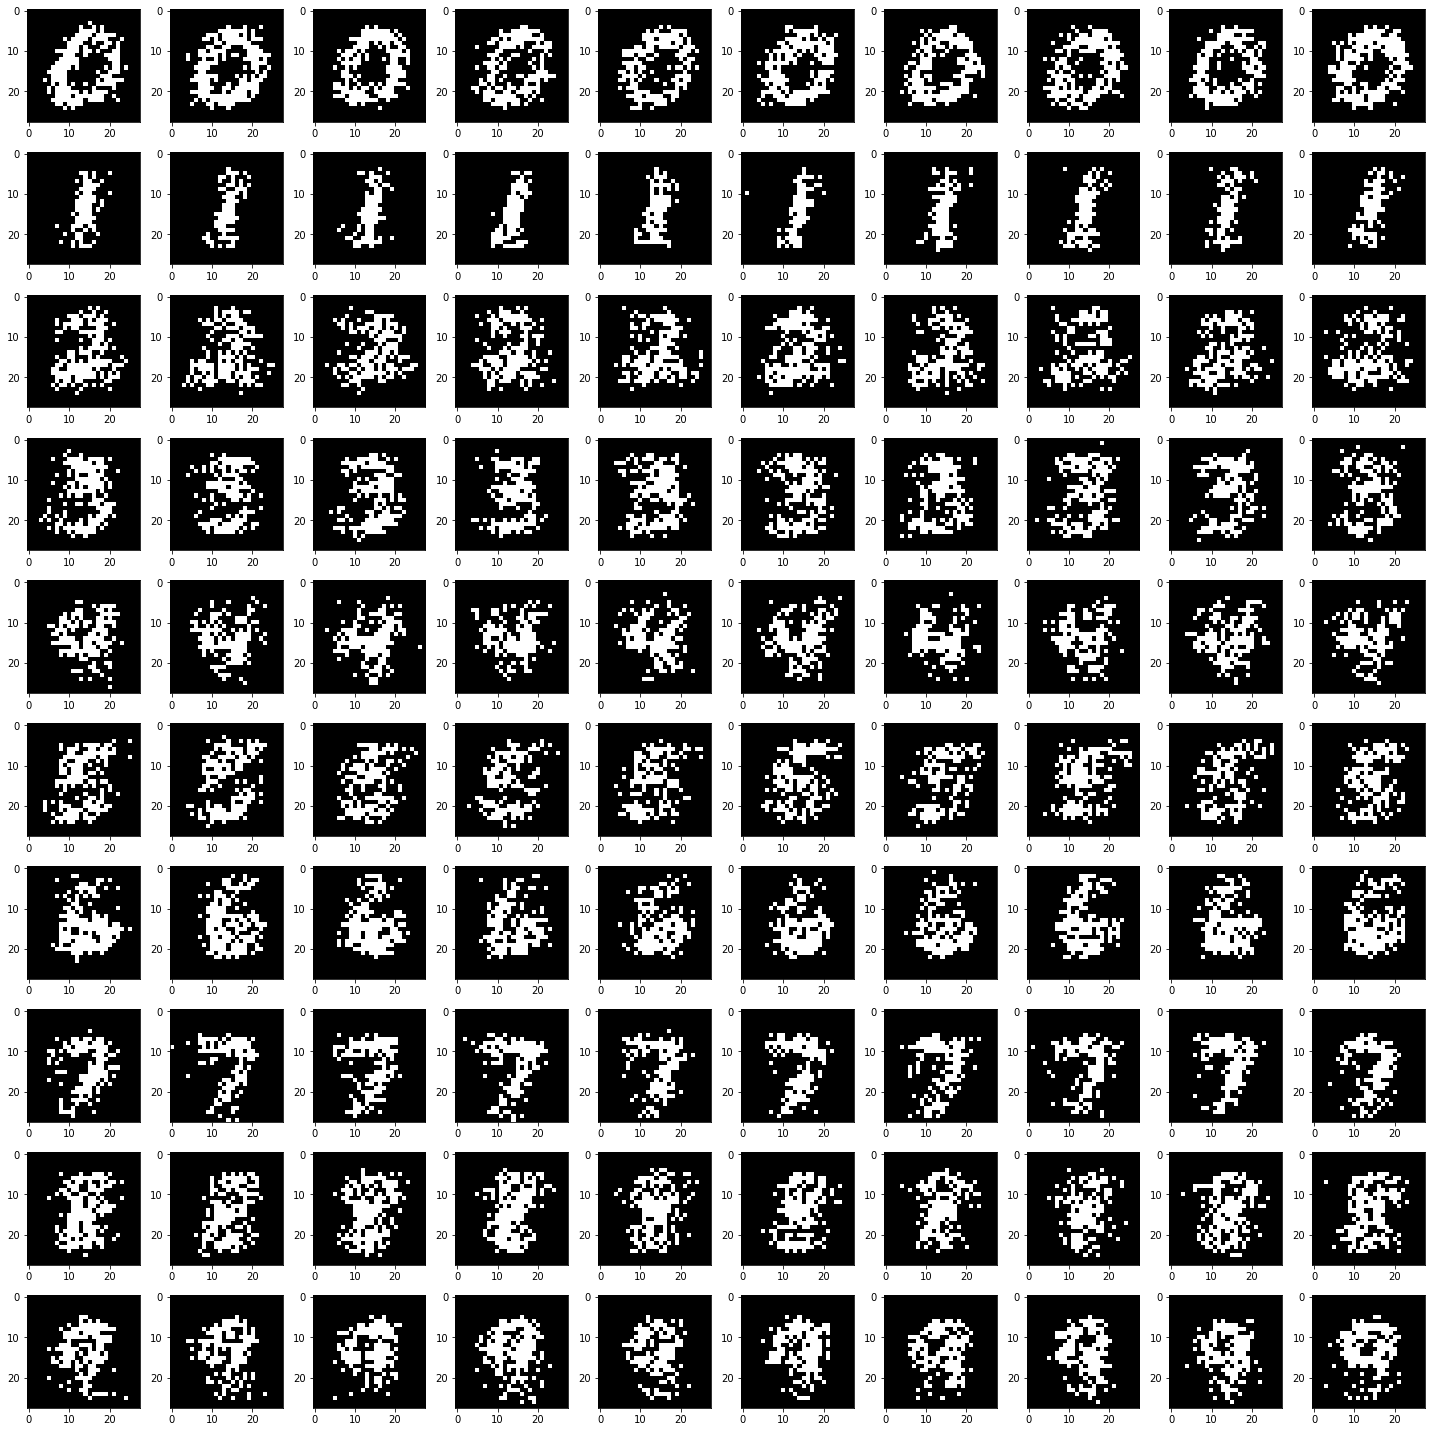


Images of some digits from binarized training data


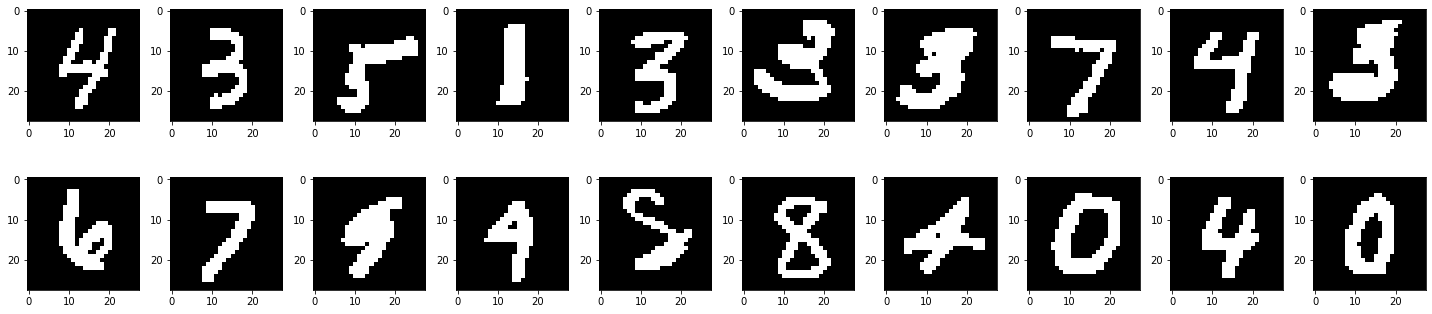

In [8]:
def Q5(num_examples):

### STUDENT START ###
    bin_mini_train_data = np.zeros(mini_train_data.shape) # create an all 0 array
    
    bin_mini_train_data[(mini_train_data >= 0.1)] = 1 # flip to 1 based on threshold (0.1)
    
    model_BNB = BernoulliNB(alpha=0.01) # use the best alpha (Question #3) for the data
    model_BNB.fit(bin_mini_train_data, mini_train_labels)
    
    model_BNB_prob = model_BNB.feature_log_prob_ # extract the probabilities for each pixel
    print("Shape of model_BNB_prob:", model_BNB_prob.shape)
    
    # model_BNB_prob is a matrix with 10 rows (0 - 9) and 784 columns, with probability for
    # each pixel, for each digit. Row i is for digit i with each column for row i holding the
    # log probability value.
    cols = model_BNB_prob.shape[1] # extract the number of columns in model_BNB_prob
    img_sz = int(np.sqrt(cols))
    
    print()
    print("Generated Digits:")
    fig, axes = plt.subplots(nrows=model_BNB_prob.shape[0], ncols=num_examples, figsize=(20, 20))
    
    for i in range(0, num_examples): # the 2 for loops are for the 10x10 grid to generate numbers
        for j in range(0, model_BNB_prob.shape[0]):
            rand_digit = np.random.rand(cols) # row vector of 784, each a random # between 0 & 1
            digit_pixel = np.zeros(cols) # start with set all pixel to 0
            for k in range(cols): # sweep through the elements of digit_pixel
                if rand_digit[k] <= np.exp(model_BNB_prob[j][k]): # compare the probabilities
                    digit_pixel[k] = 1 # flip to 1 if rand_digit lower than model probability

            digit_px_image = digit_pixel.reshape(img_sz, img_sz)
            ax = axes[j, i]
            ax.imshow(digit_px_image, cmap="gray")
     
    fig.tight_layout()
    plt.show()
    
    # show images from some of binarized trainig data
    print()
    print("Images of some digits from binarized training data")
    fig, axes = plt.subplots(nrows=2, ncols=10, figsize=(20, 5))
    for i in range(1, 11): 
        digit_px = bin_mini_train_data[i*30-1]
        digit_px_image = digit_px.reshape(28, 28) 
        ax = axes[0, i-1] 
        ax.imshow(digit_px_image, cmap="gray")
    for i in range(11, 21):
        digit_px = bin_mini_train_data[i*50-1]
        digit_px_image = digit_px.reshape(28, 28) 
        ax = axes[1, i-11] 
        ax.imshow(digit_px_image, cmap="gray")
    
    fig.tight_layout()
    plt.show()
            
### STUDENT END ###

Q5(10)

ANSWER: 
Clearly, the generated images (the 1st 10x10 grid) are more grainy compared to the images generated from the binarized training data (the last two rows). The amount of quantization noise added during binarization (separation into 0 and 1 based on threshold) is lower than the noise we add when we quantize by comparing to randomly generated values to decide between pixel values of 0 and 1.

### Question 6: Model Calibraiton
---
Recall that:
 * a **strongly calibrated** classifier is rougly 90% accurate when it says it is 90% accurate. The model's estimated posterior probability of the predicted class is indeed 0.9. 
 * A **weakly calibrated** classifier is more accurate when it "says" it is more accurate. The actual accuracy is higher when the model's estimated posterior probability is higher.
 * A **poorly calibrated** classifier has no positive correlation between the model's estimate posterior probability and the actual accuracy.

1. Produce a Bernoulli Naive Bayes model.  
1. Evaluate performance: 
  1. Partition the dev set into several buckets based on the estimated posterior probabilities of the predicted classes (predict_proba)
    - Think of it as a bin in a histogram, where each bin groups a range of estimated posterior probabilities of the predicted classes (predict_proba).
    - Then estimate the actual accuracy the classifier achieved for each bucket. 
    - So, for each prediction:
       - Find the bucket whose range includes the estimated posterior probability, 
       - and update "correct" and "total" counters accordingly. 
       - Show the accuracy for each bucket.
1. How would you characterize the calibration for this Bernoulli Naive Bayes model according to the definitions above?

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.



In [10]:
def Q6(buckets, correct, total):
    
### STUDENT START ###

    bin_mini_train_data = np.zeros(mini_train_data.shape) # create an all 0 array
    bin_dev_data = np.zeros(dev_data.shape)
    
    bin_mini_train_data[(mini_train_data >= 0.1)] = 1 # flip to 1 based on threshold (0.1)
    bin_dev_data[(dev_data >= 0.1)] = 1
    
    model_BNB = BernoulliNB(alpha=0.01) # use the best alpha (Question #3) for the data
    model_BNB.fit(bin_mini_train_data, mini_train_labels)
    
    y_pred = model_BNB.predict(bin_dev_data)
    y_posterior = model_BNB.predict_proba(bin_dev_data)
    
    print("Posterior Probability Matrix shape:", y_posterior.shape)
    print("First row of the Probability Matrix:")
    print(y_posterior[0])
    print("First digit in the predicted value y_pred:", y_pred[0])
    
    # Posterior probability matrix has the probability for each label (in y_pred) for 
    # each digit. This matrix has 1000 rows (one corresponding to each predicted 
    # value in y_pred) and 10 rows (the probability value for each of the digits).
    
    # From the print displays of the first row of the probability matrix it's clear 
    # that the predicted digit is extremely likely to be 8. All probability values, 
    # except the 8th (counting from 0) is extremely small, and the one for digit 8 
    # is very close to 1. This is further confirmed by the first value of the y_pred 
    # vector.
    
    y_pred_digit_prob = [] # init list to get prob associated with each y_pred digit in y_pred
    for i in range(len(y_pred)): # for each predicted digit
        digit = int(y_pred[i]) # get the int equivalent of the digit
        y_pred_digit_prob.append(y_posterior[i][digit]) # extract digit probability 
        
    print("Probabilty of digit", y_pred[0], "is", y_pred_digit_prob[0])
    
    # for each digit probability check which bucket value in the buckets list it falls.
    # Increment total for that bucket. Then match the predicted and actual value. If
    # matched then increment the counter corresponding to the bin in the correct list.
    for i in range(len(y_pred_digit_prob)):
        for j in range(len(buckets)):
            if y_pred_digit_prob[i] <= buckets[j]: # found the bucket from the bucket list
                total[j] += 1 # increment total for that bucket
                if y_pred[i] == dev_labels[i]: # if predicted and actual value are equal
                    correct[j] += 1 # then increment the correct counter for that bucket
                break;
    
    print()
    print("Probability Bucket", "  Total ", " Correct  ", " Accuracy")            
    for i in range(len(buckets)):
        if total[i] !=0: 
            accuracy = correct[i] / total[i]
            print("  %1.13f" % buckets[i], "   %4d  " % total[i], "  %3d   " % correct[i], "    %0.3f" % accuracy) 
        else:
            print("  %1.13f" % buckets[i], "   %4d  " % total[i], "  %3d   " % correct[i], "      NA ")
        
        

### STUDENT END ###

buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
correct = [0 for i in buckets]
total = [0 for i in buckets]

Q6(buckets, correct, total)

Posterior Probability Matrix shape: (1000, 10)
First row of the Probability Matrix:
[2.47063408e-72 3.86021681e-69 1.64081052e-14 1.13922696e-05
 4.43274541e-22 5.68633943e-14 8.64043057e-22 2.08222118e-40
 9.99988608e-01 4.18481328e-35]
First digit in the predicted value y_pred: 8
Probabilty of digit 8 is 0.999988607730279

Probability Bucket   Total   Correct    Accuracy
  0.5000000000000       0       0          NA 
  0.9000000000000      36      14        0.389
  0.9990000000000      61      28        0.459
  0.9999900000000      69      39        0.565
  0.9999999000000      53      31        0.585
  0.9999999990000      51      42        0.824
  0.9999999999900      47      37        0.787
  0.9999999999999      49      39        0.796
  1.0000000000000     634     600        0.946


ANSWER: 
The calibration is suboptimal. The total numbers we hit until 0.9999999 is less than 25%, and the accuracy is less than 0.52 In some sense we might have been better off starting from 0.9999999. The last bucket (1.0) gives a high accuracy. The accuracy number sounds somewhat over confident. 

### Question 7 EXTRA CREDIT: Feature generation
---
1. Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.
1. Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

**Note that improving results is actually hard.**

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try implementing [*maxpool*](https://computersciencewiki.org/index.php/Max-pooling_/_Pooling) features, taking a rolling maximum over sub-regions of a the image. 
- In any case, you can either transform the original data or add new "features" to it.

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [41]:
def Q7():

### STUDENT START ###
    def weighted_blur(image_data, nbrs=8):
        sz = int(np.sqrt(image_data.shape[1])) # sqrt(784) for shaping into matrix
        nbr_cnt = int(np.log2(nbrs)) # number of neighbor rows/columns for each pixel
        wt = np.arange(.1, 1, .1).reshape(nbr_cnt, nbr_cnt) # used in weighthed avg. calc
        wt_image_data = np.empty([0, image_data.shape[1]]) # init, to append new images
        
        for i in range(len(image_data)): # for every image in the data
            image = (image_data[i]).reshape(sz, sz) # make it into 28x28 matrix
            new_image = np.copy(image) # make a copy to overwrite with weighted calculations
            image = np.pad(image, 1, mode='constant') # pad with 0s around to get 30x30 matrix
            
            for row in range(len(image) - 2): # for every row except padded rows
                for col in range(len(image) - 2): # for evey col except padded cols
                    new_image[row][col] = np.average(image[row: row+nbr_cnt, col: col+nbr_cnt], 
                                                     weights=wt) # weighted sum for new pixel
            
            new_image = new_image.flatten() # convert 28x28 array into 1-dim array
            wt_image_data = np.append(wt_image_data, [new_image], axis=0) # same shape as image_data
                   
        return(wt_image_data)
    
    def bin_maxpool(d, threshold = 0.4, sub_sz=2):
        '''d: data in n x 784 size, threshold: the threshold for flipping the pixel to 0 or 1, and
           sub_sz: the sub size square matrix. For each row in d, generate the 28x28 matrix. For each 2x2 
           (sub_sz x sub_sz) non-overlapping sub-matrix compute the max, compare to threshold, set it 0 or 1.
        '''
        
        bin_maxpool_img = np.empty([0, d.shape[1]])
        
        for rows in range(d.shape[0]): # for each image in d
            img = d[rows] 
            img = img.reshape(28, 28) # get the 28x28 version of the pixels
            maxpool_arr = np.zeros(img.shape) # init an array
            i = 0
            while i <= img.shape[0] - sub_sz: # for all rows
                j = 0
                while j <= img.shape[1] - sub_sz: # for all cols
                    if np.max(img[i:i+sub_sz, j:j+sub_sz]) > threshold: # get sub-matrix max and compare
                        maxpool_arr[i:i+sub_sz, j:j+sub_sz] = 1
                    else:
                        maxpool_arr[i:i+sub_sz, j:j+sub_sz] = 0
                    j += sub_sz
                i += sub_sz
            maxpool_arr = maxpool_arr.flatten()
            bin_maxpool_img = np.append(bin_maxpool_img, [maxpool_arr], axis=0)
                
        return bin_maxpool_img

    
    # First blur the trainining and dev data, using the weighted_blur function written for Q1. Then, 
    # we apply binarization to the data to see if we can get better accuracy.
    blur_train_data = weighted_blur(mini_train_data)
    blur_dev_data = weighted_blur(dev_data)
    
    bin_blur_train_data = np.zeros(blur_train_data.shape) # create an all 0 array
    bin_blur_dev_data = np.zeros(blur_dev_data.shape)
    
    bin_blur_train_data[(blur_train_data >= 0.35)] = 1 # flip to 1 based on threshold (0.1)
    bin_blur_dev_data[(blur_dev_data >= 0.35)] = 1
    
    model_BNB = BernoulliNB(alpha=0.015) 
    model_BNB.fit(bin_blur_train_data, mini_train_labels)
    
    y_pred = model_BNB.predict(bin_blur_dev_data)
    accuracy = model_BNB.score(bin_blur_dev_data, dev_labels)
    print("Accuracy with Blurring and Binarization:", accuracy)   

    # Try with maxpool concept.
    bin_pool_train = bin_maxpool(mini_train_data, threshold=0.7)
    bin_pool_dev = bin_maxpool(dev_data, threshold=0.7)
    
    model_BNB = BernoulliNB(alpha=0.001) # use the best alpha (Question #3) for the data
    model_BNB.fit(bin_pool_train, mini_train_labels)
    
    accuracy = model_BNB.score(bin_pool_dev, dev_labels)
    print("Accuracy with maxpool and binarization:", accuracy)   

### STUDENT END ###

Q7()

Accuracy with Blurring and Binarization: 0.839
Accuracy with maxpool and binarization: 0.82


The act of blurring, followed by binarization, seems to add a 1% increase in accuracy. However, maxpool and binarization doesn't improve much, while it doesn't degrade a whole lot either.